### Consumption Smoothing Models

Seho Jeong, Sogang University

References:
- **Kwak, Jun Hee. 2025.** "Lectures on Macroeconomics." Sogang University.
- **Sargent, Thomas J. and John Stachurski. n.d.** "Consumption Smoothing." A First Course in Quantitative Economics with Python. https://intro.quantecon.org/cons_smooth.html
- **Sargent, Thomas J., and John Stachurski. n.d.** "Optimal Savings I: Value Function Iteration." Quantitative Economics with JAX. https://jax.quantecon.org/opt_savings_1.html.

In [1]:
# Import libraries.
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass

from time import time
from tqdm.auto import tqdm

In [2]:
jax.config.update('jax_enable_x64', True)

In [3]:
# Define customized colormap for plots.
cm = ['#116FA1', '#2DC0D2', '#E0B266', '#00979F', '#70CAC6', '#005A7D']
bg = '#F9F9F9'

#### Finite-Horizon Consumption-Savings Model

In [14]:
# Set parameters.
T = 60   # planning horizon
β = 0.96 # discount factor
R = 1.02 # gross interest rate
σ = 2.0  # CRRA
w = 1.0  # labor income; wage

# Set grids.
amin, amax, anum = 0.0, 10.0, 100
agrid = np.linspace(amin, amax, anum)

# Define felicity.
def u(c):
    """
    period utility function
    """
    if σ == 1:
        return np.where(c > 0, np.log(c), -np.inf)
    return np.where(c > 0, (c ** (1 - σ) - 1) / (1 - σ), -np.inf)

# Initialize value and policy functions.
V = np.zeros((T+2, anum))         
a_policy_idx = np.zeros((T+1, anum))

# Solve the problem using the backward induction.
for t in range(T, -1, -1):

    V_next = V[t+1]
    V_now = np.empty((anum, ))
    a_star_now = np.empty((anum, ))

    for ai, a in enumerate(agrid):

        c_vec = a * R + w - agrid   # consumption for every choice a_{t+1}
        RHS = u(c_vec) + β * V_next

        max_idx = RHS.argmax()      # index of maximizer a_{t+1}
        max_value = RHS[max_idx]    # maximized value RHS(a_{t+1})

        V_now[ai] = max_value
        a_star_now[ai] = max_idx    # store the index of optimal choices
    
    V[t] = V_now
    a_policy_idx[t] = a_star_now

# Translate indices into actual asset levels.
a_policy_val = agrid[a_policy_idx.astype(int)]

idx0 = np.searchsorted(agrid, 0.0)
print(f"c₀  = { (R)*0 + w - a_policy_val[0,idx0]:.3f}")
print(f"a₁* = { a_policy_val[0,idx0]:.3f}")

c₀  = 1.000
a₁* = 0.000


/var/folders/n5/bkphn15s0kzc1lsr8x64v8y00000gn/T/ipykernel_1263/1524877125.py:19: RuntimeWarning: divide by zero encountered in reciprocal
  return np.where(c > 0, (c ** (1 - σ) - 1) / (1 - σ), -np.inf)


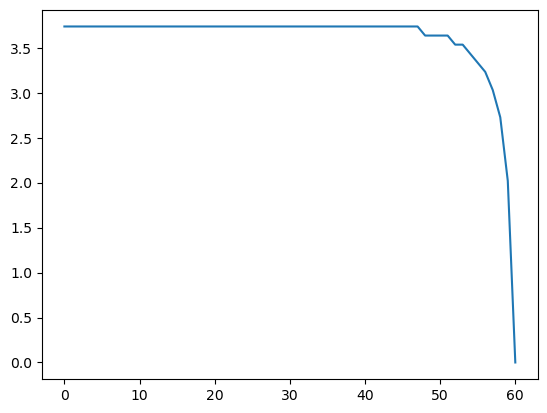

In [15]:
plt.plot(a_policy_val[:, 40])

#### Infinite-Horizon Consumption-Savings Model

In [ ]:
def create_consumption_model(R=1.01,    # gross interest rate
                             β=0.98,    # time discount factor
                             γ=2,       # CRRA parameter
                             amin=0.01, # min. asset
                             amax=5.0,  # max. asset
                             anum=150,  # number of grid points for asset
                             ρ=0.9,     # income parameters
                             ν=0.1,
                             wnum=100): 